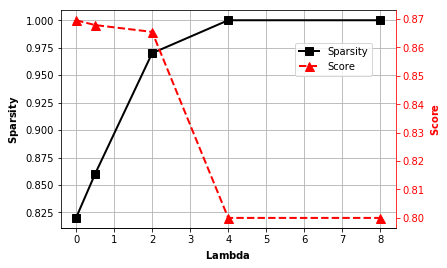

In [199]:
import cv2
import os
import torch 
import numpy as np
import sys
import matplotlib.pyplot as plt

lambda_i = [0, 0.5, 2, 4, 8]

# C3D
# axis_y = [0.967114, 0.967, 0.964492, 0.960856, 0.949976]
# sparsity = [0.64, 0.89, 0.90, 0.96, 0.97]
# lable_2 = 'Accuracy'
# label_data = ["(0, 0, 0, 0, 0, 0, 0, 0)",
#               "(3, 3, 3, 3, 3, 3, 3, 3)",
#               "(7, 2, 3, 2, 3, 3, 4, 4)",
#               "(10, 7, 5, 5, 5, 5, 5, 2)",
#               "(17, 9, 5, 5, 6, 6, 6, 5)"
#             ]
# 3D Unet
axis_y = [0.8695406, 0.8678476, 0.8654427, 0.8, 0.8]
label_2 = 'Score'
sparsity = [0.82, 0.86, 0.97, 1, 1]
label_data = ["(0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",
              "(0, 0, 0, 1, 1, 1, 1, 1, 1, 1,   1, 1, 1, 1, 1, 1, 1, 1, 1, 1,   1, 1, 1, 1, 1, 1, 1, 1, 0, 0)",
              "(0, 1, 4, 5, 3, 3, 4, 4, 5, 5,   5, 5, 4, 5, 5, 5, 4, 5, 5, 5,   5, 5, 5, 5, 5, 5, 5, 5, 5, 5)",
              "(0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",
              "(0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",
            ]

fig, ax = plt.subplots(1,1)
color = (0, 0, 0)
ax.plot(lambda_i, sparsity, 'x-', marker='s', color=color,  linewidth=2, markersize=8, label='Sparsity')
# for i in range(5):
#     ax.text(lambda_i[i], sparsity[i],label_data[i], verticalalignment='top', horizontalalignment='right' )
ax.set_xlabel(r"$\bf{Lambda}$"+' ' + r"$\bf{}$", size=10, family="Arial")
ax.set_ylabel(r"$\bf{Sparsity}$"+' ' + r"$\bf{(%)}$", size=10, color=color)

plt.grid(True)
from matplotlib.pyplot import MultipleLocator
inst = plt.gca()

ax1 = ax.twinx()
color1 = (1, 0, 0)
ax1.plot(lambda_i, axis_y, '--', marker='^', color=color1,  linewidth=2, markersize=9, label=label_2)
ax1.set_ylabel(r"$\bf{"+ label_2+"}$"+' ' + r"$\bf{}$", size=10, color=color1)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=(0.7, 0.7))

ax.spines['left'].set_color(color)
ax.tick_params(axis='y', colors=color)

ax.spines['right'].set_visible(False)

ax1.spines['right'].set_color(color1)
ax1.tick_params(axis='y', colors=color1)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.savefig(os.path.join(sys.path[0],'lambda.svg'), format='svg')
plt.show()

In [196]:
# compute whole sparsity after given threshold combinations and numbers of IA in each layer
ifm_size = [140, 39, 10.4, 3.2, 0.6, 0.35, 2.8, 11.2, 45, 135]
# density_th_layer0 = [20, 18, 17, 16, 15, 14 ,13, 12, 11, 10]
# for x in range(10, 20):
#     proportion_th[0][x] = density_th_layer0[x -10]
def whole_density(ifm_size, proportion_th, threshold, n_layer):
    density = 0
    for i in range(n_layer):
        density += proportion_th[i][threshold[i]]*ifm_size[i] / sum(ifm_size)

    return density

threshold_comb =[   
                [0, 0, 0, 0, 0,   0, 0, 0, 0, 0],
                [1, 1, 1, 1, 1,   1, 1, 1, 1, 0],
                [3, 4, 5, 5, 5,   5, 5, 5, 5, 5]
                ]

for threshold in threshold_comb:
    print("whole density is: {}".format(whole_density(ifm_size, proportion_th, threshold, 10)))

whole density is: 18.21169940189008
whole density is: 14.124194470481232
whole density is: 3.3984906912720945


In [233]:
####################################################################################################################
# distribution
#################################################################################################################### 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import statistics
import datetime   

# config parameters
network = '3dunet' # '3dunet'
csv_name = 'origin.csv'
fig_name = 'origin_distribution.svg'
stat_type = 'distribution' # what is stated: distribution or density_th(after threshold)  
relative = False # whether compared to density of th=0
xlabel = 'Value'
tdvd_range = 10 # range of value
n_layer = 10 # number of layers

date_str = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
data = pd.read_csv(os.path.join('../source',network, csv_name ))
proportion = data.iloc[-1,2:] 
print(len(proportion))
range_idx = (2*tdvd_range+1)

if network == '3dunet': # concate convs to one layer for 3dunet
    for i in range(range_idx):
        for idx_encoder in range(5):
            proportion[i + range_idx*idx_encoder] = (proportion[i+range_idx*4*idx_encoder] + proportion[i+range_idx+range_idx*4*idx_encoder] +\
                                                    proportion[i+range_idx*2 + range_idx*4*idx_encoder] + proportion[i+range_idx*3+range_idx*4*idx_encoder])/4
        for idx_decoder in range(5):
            proportion[i + range_idx*idx_decoder + range_idx*5] = (proportion[i+range_idx*2*idx_decoder + range_idx*4*5] + proportion[i+range_idx+range_idx*2*idx_decoder  + range_idx*4*5])/2



630


layer: 0, threshold: 0, real density: 11.0
layer: 0, threshold: 1, real density: 9.0
layer: 0, threshold: 2, real density: 1.6
layer: 0, threshold: 3, real density: 0.3
layer: 0, threshold: 4, real density: 0.1
layer: 0, threshold: 5, real density: 0.0
layer: 0, threshold: 6, real density: 0.0
layer: 0, threshold: 7, real density: 0.0
layer: 0, threshold: 8, real density: 0.0
layer: 0, threshold: 9, real density: 0.0
layer: 1, threshold: 0, real density: 10.4
layer: 1, threshold: 1, real density: 9.3
layer: 1, threshold: 2, real density: 0.9
layer: 1, threshold: 3, real density: 0.2
layer: 1, threshold: 4, real density: 0.1
layer: 1, threshold: 5, real density: 0.0
layer: 1, threshold: 6, real density: 0.0
layer: 1, threshold: 7, real density: 0.0
layer: 1, threshold: 8, real density: 0.0
layer: 1, threshold: 9, real density: 0.0
layer: 2, threshold: 0, real density: 17.8
layer: 2, threshold: 1, real density: 12.4
layer: 2, threshold: 2, real density: 3.0
layer: 2, threshold: 3, real d

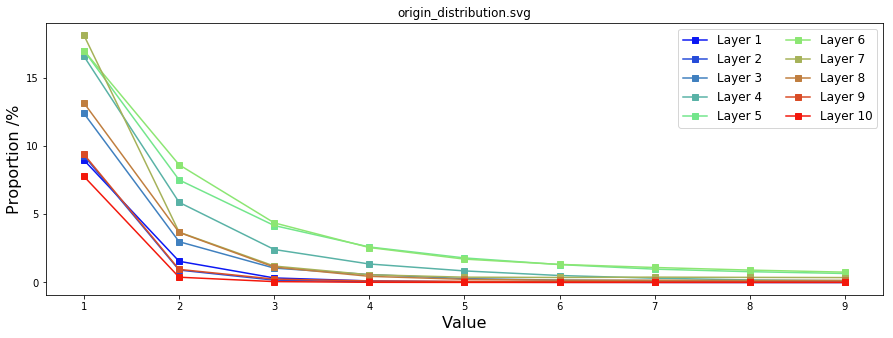

In [236]:
from matplotlib import pyplot as plt
from matplotlib import colors
cdict = {'red':   ((0.0,  0.0, 0.0),
                   (0.5,  0.5, 0.5),
                   (1.0,  1, 1.0)),

         'green': ((0.0,  0, 0.0),
                   (0.5,  1, 1),
                   (1.0,  0, 0.0)),

         'blue':  ((0.0,  1, 1),
                   (0.5,  0.5, 0.5),
                   (1.0,  0, 0))}
cmap = colors.LinearSegmentedColormap('custom', cdict)

plt.figure(figsize=(15,5))
plt.title(fig_name)
proportion_th = np.zeros(shape=(n_layer,range_idx ))
for layer in range(n_layer):
    proportion_th[layer][0] = 100 -  proportion[tdvd_range + range_idx*layer]
    x = []
    y = []
    for th in range(1,tdvd_range):
        if stat_type == 'distribution':
            proportion_th[layer][th] = proportion[tdvd_range -th + range_idx*layer] +\
                proportion[tdvd_range +th + range_idx*layer]  
        else:
            proportion_th[layer][th] = (proportion_th[layer][th-1] - proportion[tdvd_range -th + range_idx*layer] -\
                            proportion[tdvd_range +th + range_idx*layer] ) 
        x.append(th)
        y.append(proportion_th[layer][th]/ (proportion_th[layer][0]*100 if relative else 1))
    for th in range(0, tdvd_range):
        print("layer: {}, threshold: {}, real density: {:.1f}".format(layer, th, proportion_th[layer][th]))
    plt.plot(np.array(x), np.array(y),label="Layer "+str(layer+1), color=cmap(0.1*layer+0.05), linestyle='-',marker='s' )

plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.xlabel(xlabel, fontsize=16)
plt.ylabel('Proportion /%', fontsize=16)
plt.legend(fontsize=12,ncol=2)   #显示标签
# plt.savefig(os.path.join('../generate', network, date_str+'_'+csv_name +'_' +fig_name), format='svg')  

In [172]:
# compute whole sparsity after given threshold combinations and numbers of IA in each layer
ifm_size = [0.6, 3, 0.75, 1.5, 0.2, 0.4, 0.05, 0.05]
density_th_layer0 = [20, 18, 17, 16, 15, 14 ,13, 12, 11, 10]
for x in range(10, 20):
    proportion_th[0][x] = density_th_layer0[x -10]
def whole_density(ifm_size, proportion_th, threshold, n_layer):
    density = 0
    for i in range(n_layer):
        density += proportion_th[i][threshold[i]]*ifm_size[i] / sum(ifm_size)

    return density

threshold_comb =[   
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [3, 3, 3, 3, 3, 3, 3, 3],
                    [7, 2, 3, 2, 3, 3, 4, 4],
                    [10,7, 5, 5, 5, 5, 5, 2],
                    [17,9,5, 5, 6, 6, 6, 5]
                ]

for threshold in threshold_comb:
    print("whole density is: {}".format(whole_density(ifm_size, proportion_th, threshold, 8)))

whole density is: 35.98480255114504
whole density is: 8.908366567175571
whole density is: 9.98160710534351
whole density is: 3.8561201106870233
whole density is: 2.7490990946564886
